In [34]:
import pandas as pd
import numpy as np
import cleaner
import re
import torch
import nltk

from tqdm import tqdm
from nltk import word_tokenize
from nltk.corpus import stopwords
from transformers import AutoTokenizer, AutoModel
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stopwords_en = stopwords.words('english')

lemmatizer = WordNetLemmatizer()

bert_tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
bert_model = AutoModel.from_pretrained("microsoft/codebert-base")

tqdm.pandas()

[nltk_data] Downloading package stopwords to /home/ae/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ae/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ae/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [35]:
TARGET = [
    'C', 'C#', 'C++', 'Dart', 'Elixir', 'Go', 'JSON', 'Java', 
    'Javascript', 'Julia', 'Kotlin', 'Markdown', 'Ruby', 'Rust', 'Python'
]

In [36]:
df = pd.read_csv("/home/ae/repos/archivos/dataset.csv")
df = df[df['language'].isin(TARGET)]

del df['file_size']
del df['line_count']
del df['extension']

df.head()

,id,file_path,language
0,1,Markdown/000001.md,Markdown
3,4,Markdown/000004.md,Markdown
4,5,Markdown/000005.md,Markdown
5,6,Markdown/000006.md,Markdown
6,7,JSON/000007.json,JSON


In [37]:
def read_content(path, origin):
    path = origin + "/" + path
    
    file = open(path, 'rb')
    contents = file.read().decode(errors = "ignore")
    file.close()
    
    return contents

In [38]:
df['source'] = df['file_path'].progress_apply(lambda x: read_content(x, "/home/ae/repos/archivos/dataset"))
df.head()

100%|██████████████████████| 74851/74851 [00:14<00:00, 5018.07it/s]


,id,file_path,language,source
0,1,Markdown/000001.md,Markdown,# Contributing\n\n| Component | Bui...
3,4,Markdown/000004.md,Markdown,# Azure SDK for .NET\n\n[![Packages](https://i...
4,5,Markdown/000005.md,Markdown,<!-- BEGIN MICROSOFT SECURITY.MD V0.0.5 BLOCK ...
5,6,Markdown/000006.md,Markdown,# Support\n\n## How to file issues and get hel...
6,7,JSON/000007.json,JSON,"{\n ""$schema"": ""https://raw.githubusercontent..."


In [39]:
df_clean = df.copy()
df_dirty = df.copy()

In [40]:
def clean_comments(contents, language) -> str:
    delimiters = cleaner.lang(language)
    
    if delimiters is not None:
        contents = cleaner.string(contents, *delimiters)
        
    return contents

def clean_extras(contents) -> str:
    contents = re.sub(r'[\r]', '', contents)
    contents = re.sub(r'\w{15,}', '', contents)
    contents = re.sub('[\n]{2,}', '\n', contents)
    contents = re.sub('[\t]{2,}', '\t', contents)
    contents = re.sub(r'[ ]+', ' ', contents)

    contents = "\n".join([line for line in contents.splitlines() if len(line.strip()) != 0])

    return contents

def tokenize(source: str) -> torch.Tensor:
    tokens = bert_tokenizer.tokenize(source)
    lemmas = (lemmatizer.lemmatize(token) for token in tokens if token not in stopwords_en)
    return bert_tokenizer(code, return_tensors="pt", truncation=True, max_length=512)
    
def vectorize(tokens: torch.Tensor) -> np.ndarray:    
    with torch.no_grad():
            outputs = bert_model(**inputs)
        
    # We use the [CLS] token's embedding as the representation of the entire code snippet
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()

    return cls_embedding

In [41]:
df_clean['source'] = df_clean.progress_apply(lambda r: clean_comments(r.source, r.language), axis=1)
df_clean.head()

100%|██████████████████████| 74851/74851 [00:08<00:00, 8604.09it/s]


,id,file_path,language,source
0,1,Markdown/000001.md,Markdown,# Contributing\n\n| Component | Bui...
3,4,Markdown/000004.md,Markdown,# Azure SDK for .NET\n\n[![Packages](https://i...
4,5,Markdown/000005.md,Markdown,\n\n## Security\n\nMicrosoft takes the securit...
5,6,Markdown/000006.md,Markdown,# Support\n\n## How to file issues and get hel...
6,7,JSON/000007.json,JSON,"{\n ""$schema"": ""https:\n ""meta"": {\n ""aut..."


In [42]:
df_clean['source'] = df_clean['source'].progress_apply(clean_extras)
df_dirty['source'] = df_dirty['source'].progress_apply(clean_extras)

100%|██████████████████████| 74851/74851 [01:00<00:00, 1240.37it/s]


In [43]:
def split_code_into_chunks(code, max_chars):
    lines = code.split('\n')
    chunks = []
    current_chunk = []
    current_length = 0
    
    for line in lines:
        token_len = len(tokenize(line))
        if current_length + token_len + 1 > max_chars:
            chunks.append('\n'.join(current_chunk))
            current_chunk = [line]
            current_length = token_len + 1  # +1 for the newline character
        else:
            current_chunk.append(line)
            current_length += token_len + 1  # +1 for the newline character
    
    # Add the last chunk
    # if current_chunk:
        # chunks.append('\n'.join(current_chunk))
    
    return chunks


In [44]:
def gen_chunk_entries(df: pd.DataFrame, ENTRIES = 3000, MAX_CHARS = 512) -> pd.DataFrame:
    status = {}
    bufs = {}
    
    for lang in list(TARGET):
        status[lang] = 0
    
    new_rows = []
    total = 0

    with tqdm(total=ENTRIES * len(TARGET), position=0, leave=True) as pbar:
        for _, row in df.iterrows():
            lang = row.language
            
            if status[lang] < ENTRIES:
                for chunk in split_code_into_chunks(row.source, MAX_CHARS):
                    if status[lang] < ENTRIES:
                        new_rows.append({'language': lang, 'source': chunk})
                        status[lang] += 1
                        total += 1
                        pbar.update()

    tqdm._instances.clear()
    return pd.DataFrame(new_rows)

In [61]:
df_clean_chunks = gen_chunk_entries(df_clean, 250)
df_dirty_chunks = gen_chunk_entries(df_dirty, 250)

 96%|████████████████████████▊ | 3582/3750 [04:39<00:13, 12.84it/s]


In [62]:
df_clean_chunks['tokens'] = df_clean_chunks['source'].progress_apply(tokenize)
df_dirty_chunks['tokens'] = df_dirty_chunks['source'].progress_apply(tokenize)

100%|██████████████████████████| 3582/3582 [01:52<00:00, 31.71it/s]


In [63]:
df_clean_chunks = df_clean_chunks[df_clean_chunks['tokens'].apply(lambda x: x.shape) != (1, 0)]
df_dirty_chunks = df_dirty_chunks[df_dirty_chunks['tokens'].apply(lambda x: x.shape) != (1, 0)]

In [64]:
df_clean_chunks['vector'] = df_clean_chunks['tokens'].progress_apply(vectorize)
df_dirty_chunks['vector'] = df_dirty_chunks['tokens'].progress_apply(vectorize)

100%|██████████████████████████| 3582/3582 [41:22<00:00,  1.44it/s]


In [65]:
import numpy as np
import pandas as pd
import plotly_express as px

from sklearn.manifold import TSNE

def gen_plot(df, vec):
    tsne = TSNE(n_components=2, random_state=42, init='random')
    vis_dims = tsne.fit_transform(vec)

    return px.scatter(
        data_frame=df,
        x=vis_dims[:,0],
        y=vis_dims[:,1],
        color=df['language'],
        template='plotly_dark',
        hover_data='lang'
    )

In [66]:
mapper = {}
for i in range(len(TARGET)):
    mapper[TARGET[i]] = i

df_clean_chunks['lang'] = df_clean_chunks['language'].map(mapper)
df_dirty_chunks['lang'] = df_dirty_chunks['language'].map(mapper)

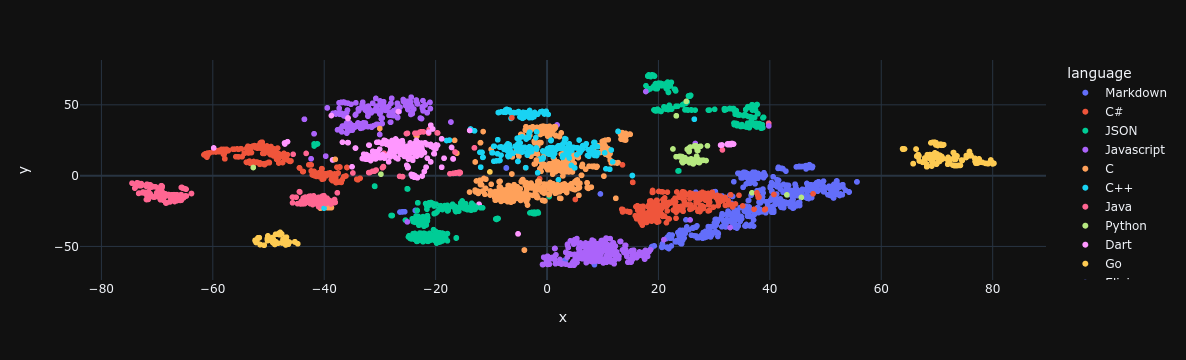

In [67]:
fig_spacy = gen_plot(
    df = df_clean_chunks,
    vec = np.vstack(df_clean_chunks['vector']).reshape(-1, 768)
)

fig_spacy.show()

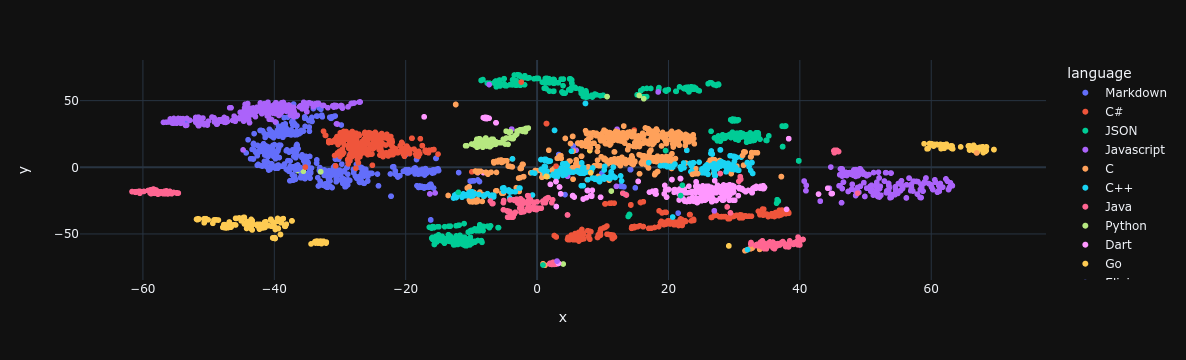

In [68]:
fig_spacy = gen_plot(
    df = df_dirty_chunks,
    vec = np.vstack(df_dirty_chunks['vector']).reshape(-1, 768)
)

fig_spacy.show()

In [69]:
df_dirty_chunks.to_pickle("bert_dirty_250x512_aprox")
df_clean_chunks.to_pickle("bert_clean_250x512_aprox")